In [1]:
import sys
!conda upgrade --yes --prefix {sys.prefix} -c conda-forge tornado

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/jschless/.conda/envs/gt:

The following packages will be UPDATED:

    tornado: 6.0.4-py38h1e0a361_1 conda-forge --> 6.1-py38h497a2fe_1 conda-forge

tornado-6.1-py 100% |################################| Time: 0:00:01 603.81 kB/s


In [ ]:
!conda upgrade --name  -c conda-forge tornado

In [2]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge tableone

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/jschless/.conda/envs/gt:

The following NEW packages will be INSTALLED:

    tableone: 0.7.10-pyhd3deb0d_0 conda-forge

tableone-0.7.1 100% |################################| Time: 0:00:00  49.70 kB/s


In [10]:
import preprocessing, cascade, numpy as np
from collections import defaultdict
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook, I'll explore the effect these different RT attribution methods had on key statistics. 

## Getting Cascades
I'll take the largest cascades and I'll exclude bandwagon hashtags 

In [2]:
pure_campaigns = {k:v for k,v in preprocessing.load_campaign().items()
                  if k not in preprocessing.bandwagon_hashtags}

In [151]:
MIN_RETWEETS = 50
min_size = lambda x: x.n_retweets > MIN_RETWEETS
cascade_list = preprocessing.process_campaign(pure_campaigns, filter_func=min_size)

100%|██████████| 68/68 [00:10<00:00,  6.60it/s]


## Creating Results Table for Structural Virality

In [5]:
# I need to go over all the cascades, load their networks (one at a time for memory purposes), 
# and record statistics. i'll make a dictionary and then convert to pandas after the fact
# result_dictionary = {'cascade_root': {'type': stat_result}}

In [6]:
def create_sv_prop_map(g):
    if 'structural_virality' in g.gp:
        return
    gprop = g.new_graph_property("float")
    g.gp['structural_virality'] = gprop
    g.gp['structural_virality'] = structural_virality(g)

In [7]:
import graph_tool.all as gt, numpy as np
def max_impressions(fg):
    return np.array([np.sum(gt.label_out_component(fg, v).a) for v in fg.vertices()])

def structural_virality(g_directed):
    # sum over all pairwise distances
    g = gt.GraphView(g_directed, directed=False)
    n = g.num_vertices()
    total = sum([gt.shortest_distance(g, i, j) for i in range(n) for j in range(i+1, n)])
    # multiple by two because we only did half the distances and its symmetric
    return 2*total/(n*n-1)

In [9]:
sv_result_dict = {}
for c in tqdm(cascade_list):
    inner_dict = sv_result_dict[c.root.id] = {}
    networks = [('temporal', ''), ('reverse-temporal', ''),
               ('proportional-followers', '0'),
                ('uniform', '0'),
                ('proportional-followers', '1'),
                ('uniform', '1'),
                ('proportional-followers', '2'),
                ('uniform', '2')]
    
    for name, n in networks:
        temp_g = c.create_network(name, suffix=n)
        if 'structural_virality' in temp_g.gp:
            sv = temp_g.gp.structural_virality
        else:
            #print('structural virality not saved, rerunning')
            c.modify_network_and_save(name, apply_func=create_sv_prop_map, 
                                      suffix=n)
            temp_g = c.create_network(name, suffix=n)
            sv = temp_g.gp.structural_virality
        inner_dict[name+n] = sv

 84%|████████▍ | 562/670 [03:15<00:37,  2.87it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/jschless/.conda/envs/gt/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-a08a63709702>", line 18, in <module>
    c.modify_network_and_save(name, apply_func=create_sv_prop_map,
  File "/home/jschless/whatsapp/TwitterCoordination/cascade.py", line 138, in modify_network_and_save
    apply_func(g)
  File "<ipython-input-6-b41a1485e066>", line 6, in create_sv_prop_map
    g.gp['structural_virality'] = structural_virality(g)
  File "<ipython-input-7-45c018564a0b>", line 9, in structural_virality
    total = sum([gt.shortest_distance(g, i, j) for i in range(n) for j in range(i+1, n)])
  File "<ipython-input-7-45c018564a0b>", line 9, in <listcomp>
    total = sum([gt.shortest_distance(g, i, j) for i in range(n) for j in range(i+1, n)])
  File "/home/jschless/.conda/envs/gt/lib/python3.8/site-packages/graph_tool/topology/__init__.

TypeError: object of type 'NoneType' has no len()

In [21]:
res_df = pd.DataFrame(sv_result_dict).T

In [22]:
res_df

,temporal,reverse-temporal,proportional-followers0,uniform0,proportional-followers1,uniform1,proportional-followers2,uniform2
1097072525337518081,2.901874,2.025792,2.066740,2.563075,2.092367,2.451667,2.077322,2.443235
1172053450093260800,5.022292,2.071685,2.264067,3.725324,2.323093,3.262662,2.364868,3.633545
1061473412265185280,10.647968,2.483044,3.036427,4.090677,2.999893,4.263911,3.035989,4.626966
1061488237095477248,3.054406,2.146364,2.451558,2.458638,2.226856,2.760446,2.598692,2.406772
1061488319719190528,2.081337,2.013391,2.013391,2.026980,2.013391,2.013391,2.040768,2.013391
...,...,...,...,...,...,...,...,...
1098805598424985600,2.359105,2.309619,2.378134,2.365125,2.378849,2.370125,2.359360,2.378134
1095238400922271745,2.848596,2.075458,2.140049,2.372527,2.139316,2.255311,2.150183,2.277656
1097018344362786821,2.330493,2.277360,2.319465,2.323030,2.324812,2.317238,2.320802,2.316569
1095245693822763009,2.344867,2.308458,2.366802,2.352329,2.368159,2.353008,2.368385,2.351425


In [24]:
res_df['uniform'] = res_df[['uniform0', 'uniform1', 'uniform2']].mean(axis=1)
res_df['proportional-followers'] = res_df[['proportional-followers1', 'proportional-followers0', 'proportional-followers2']].mean(axis=1)
res_df

,temporal,reverse-temporal,proportional-followers0,uniform0,proportional-followers1,uniform1,proportional-followers2,uniform2,uniform,proportional-followers
1097072525337518081,2.901874,2.025792,2.066740,2.563075,2.092367,2.451667,2.077322,2.443235,2.485992,2.078810
1172053450093260800,5.022292,2.071685,2.264067,3.725324,2.323093,3.262662,2.364868,3.633545,3.540511,2.317343
1061473412265185280,10.647968,2.483044,3.036427,4.090677,2.999893,4.263911,3.035989,4.626966,4.327185,3.024103
1061488237095477248,3.054406,2.146364,2.451558,2.458638,2.226856,2.760446,2.598692,2.406772,2.541952,2.425702
1061488319719190528,2.081337,2.013391,2.013391,2.026980,2.013391,2.013391,2.040768,2.013391,2.017921,2.022516
...,...,...,...,...,...,...,...,...,...,...
1098805598424985600,2.359105,2.309619,2.378134,2.365125,2.378849,2.370125,2.359360,2.378134,2.371128,2.372114
1095238400922271745,2.848596,2.075458,2.140049,2.372527,2.139316,2.255311,2.150183,2.277656,2.301832,2.143183
1097018344362786821,2.330493,2.277360,2.319465,2.323030,2.324812,2.317238,2.320802,2.316569,2.318946,2.321693
1095245693822763009,2.344867,2.308458,2.366802,2.352329,2.368159,2.353008,2.368385,2.351425,2.352254,2.367782


In [26]:
res_df = res_df.reset_index()

In [41]:
final_df = res_df[['temporal', 'reverse-temporal', 'uniform', 'proportional-followers']]

In [43]:
final_df['i'] = final_df.index

<ipython-input-43-8cf5b6619a4b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['i'] = final_df.index


<AxesSubplot:>

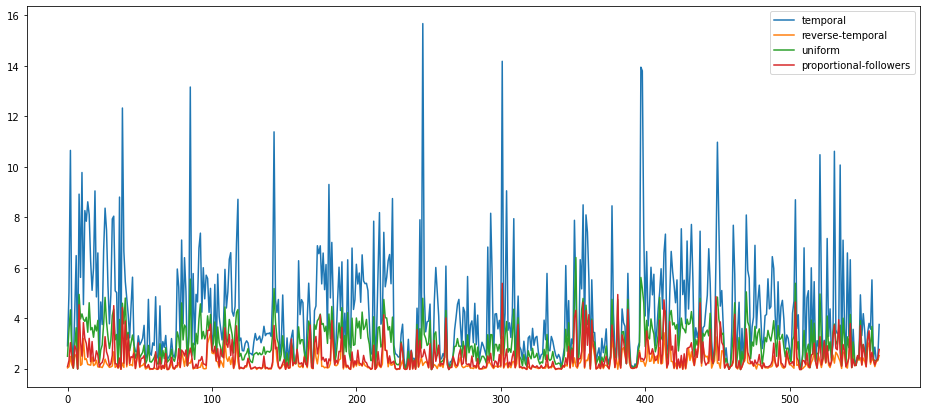

In [35]:
res_df[['temporal', 'reverse-temporal', 'uniform', 'proportional-followers']].plot(figsize=(16,7))

Text(0.5, 1.0, 'Structural Virality Boxplots')

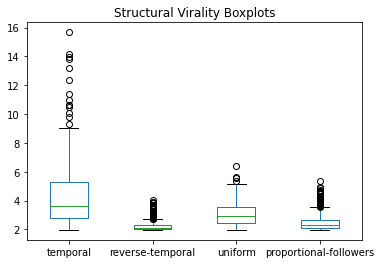

In [37]:
res_df[['temporal', 'reverse-temporal', 'uniform', 'proportional-followers']].plot.box()
plt.title('Structural Virality Boxplots')

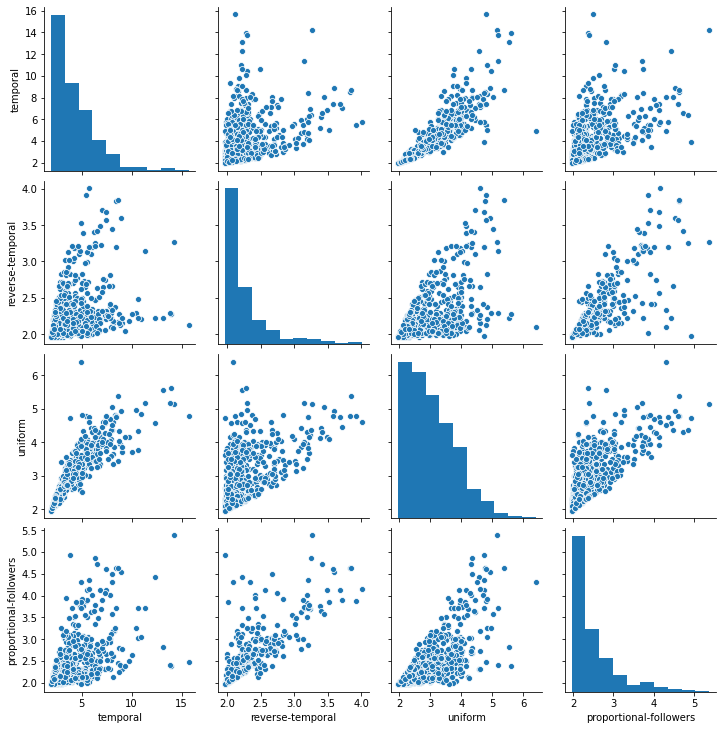

In [50]:
sns.pairplot(final_df.iloc[:,:-1])

What does this mean? It's as expected that they would be correlated, I suppose. Still, it shows that there is a lot of variability depending on the attribution method. Small structural virality is small pretty much no matter what

# Allocated Descendents
Would be interesting to explore average change, or something like that.
The problem is each cascade has a descendent distribution array. Could combine all the arrays and do a stacked histogram...

In [52]:
def create_descendents_prop_map(g):
    g.vp.n_desc = g.new_vertex_property('int')
    def get_n_descendents(g, v):
        descendents = g.get_out_neighbors(v)
        #print(v, ':', descendents)
        if len(descendents) == 0:
            g.vp.n_desc[v] = 0
        else:
            g.vp.n_desc[v] = len(descendents) + sum([get_n_descendents(g, x) for x in descendents])
        return g.vp.n_desc[v]
    get_n_descendents(g, 0)
    return g.vp.n_desc.a

In [56]:
n_descendents_result_dict = {}
for c in tqdm(cascade_list):
    res = n_descendents_result_dict[c.root.id] = {}

    temp_g = c.create_network('flow-graph')
    res['flow-graph'] = max_impressions(temp_g)
    
    networks = [('temporal', ''), ('reverse-temporal', ''),
               ('proportional-followers', '0'),
                ('uniform', '0'),
                ('proportional-followers', '1'),
                ('uniform', '1'),
                ('proportional-followers', '2'),
                ('uniform', '2')]
    
    for name, n in networks:
        temp_g = c.create_network(name, suffix=n)
        res[name+n] = create_descendents_prop_map(temp_g)

100%|██████████| 670/670 [01:53<00:00,  5.89it/s]


In [61]:
pd.DataFrame(n_descendents_result_dict).T

,flow-graph,temporal,reverse-temporal,proportional-followers0,uniform0,proportional-followers1,uniform1,proportional-followers2,uniform2
1097072525337518081,"[381, 1, 1, 2, 40, 1, 1, 7, 1, 1, 82, 1, 2, 2,...","[380, 0, 0, 0, 10, 0, 0, 0, 0, 0, 19, 0, 0, 0,...","[380, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0...","[380, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0...","[380, 0, 0, 0, 5, 0, 0, 0, 0, 0, 38, 0, 0, 0, ...","[380, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0...","[380, 0, 0, 0, 2, 0, 0, 0, 0, 0, 28, 0, 0, 0, ...","[380, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0...","[380, 0, 0, 1, 2, 0, 0, 0, 0, 0, 18, 0, 0, 0, ..."
1172053450093260800,"[246, 173, 151, 1, 3, 1, 1, 1, 1, 1, 6, 142, 1...","[245, 107, 75, 0, 0, 0, 0, 0, 0, 0, 1, 26, 0, ...","[245, 1, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0...","[245, 0, 12, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[245, 88, 44, 0, 0, 0, 0, 0, 0, 0, 3, 25, 0, 1...","[245, 0, 14, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, ...","[245, 10, 43, 0, 1, 0, 0, 0, 0, 0, 1, 25, 0, 1...","[245, 1, 11, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, ...","[245, 101, 44, 0, 0, 0, 0, 0, 0, 0, 1, 43, 0, ..."
1061473412265185280,"[422, 222, 1, 212, 326, 324, 230, 1, 227, 213,...","[421, 0, 0, 0, 286, 279, 0, 0, 208, 0, 0, 0, 0...","[421, 1, 0, 0, 8, 71, 0, 0, 1, 0, 0, 1, 0, 0, ...","[421, 0, 0, 0, 0, 149, 0, 0, 0, 0, 0, 0, 0, 0,...","[421, 0, 0, 2, 10, 152, 3, 0, 31, 5, 0, 4, 0, ...","[421, 0, 0, 0, 0, 163, 0, 0, 0, 0, 0, 0, 0, 0,...","[421, 0, 0, 0, 25, 168, 27, 0, 14, 0, 0, 36, 0...","[421, 0, 0, 0, 1, 141, 0, 0, 0, 0, 0, 0, 0, 0,...","[421, 0, 0, 0, 168, 148, 4, 0, 54, 0, 0, 2, 0,..."
1061488237095477248,"[114, 10, 1, 19, 1, 5, 18, 16, 16, 4, 1, 11, 9...","[113, 0, 0, 14, 0, 0, 13, 7, 12, 0, 0, 6, 4, 4...","[113, 2, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0...","[113, 0, 0, 10, 0, 0, 7, 3, 6, 0, 0, 0, 2, 1, ...","[113, 5, 0, 9, 0, 0, 1, 3, 1, 0, 0, 1, 4, 4, 2...","[113, 0, 0, 1, 0, 0, 0, 0, 9, 0, 0, 2, 1, 2, 0...","[113, 0, 0, 16, 0, 0, 14, 2, 7, 0, 0, 5, 3, 1,...","[113, 0, 0, 14, 0, 0, 9, 0, 8, 0, 0, 3, 1, 3, ...","[113, 0, 0, 11, 0, 0, 3, 2, 3, 1, 0, 2, 1, 2, ..."
1061488319719190528,"[142, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[141, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
...,...,...,...,...,...,...,...,...,...
1050333480062578688,"[223, 1, 31, 1, 1, 64, 13, 1, 112, 1, 62, 50, ...","[222, 0, 0, 0, 0, 5, 0, 0, 0, 0, 4, 1, 0, 0, 0...","[222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0...","[222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0...","[222, 0, 0, 0, 0, 12, 0, 0, 0, 0, 11, 7, 0, 0,...","[222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0...","[222, 0, 0, 0, 0, 0, 0, 0, 45, 0, 5, 3, 0, 0, ...","[222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0...","[222, 0, 0, 0, 0, 13, 0, 0, 1, 0, 12, 7, 0, 0,..."
1050333782665043969,"[115, 1, 49, 44, 1, 39, 48, 42, 45, 41, 91, 1,...","[114, 0, 4, 0, 0, 0, 3, 0, 1, 0, 90, 0, 40, 39...","[114, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, ...","[114, 0, 0, 0, 0, 0, 1, 0, 0, 0, 68, 0, 0, 0, ...","[114, 0, 0, 7, 0, 1, 1, 5, 18, 11, 43, 0, 1, 4...","[114, 0, 0, 0, 0, 0, 0, 0, 0, 0, 63, 0, 0, 0, ...","[114, 0, 9, 3, 0, 1, 16, 0, 8, 6, 49, 0, 3, 3,...","[114, 0, 0, 0, 0, 0, 0, 0, 0, 0, 65, 0, 0, 0, ...","[114, 0, 20, 8, 0, 0, 18, 4, 7, 14, 43, 0, 3, ..."
1050347537763319808,"[252, 110, 1, 122, 1, 126, 1, 1, 121, 126, 1, ...","[251, 0, 0, 0, 0, 0, 0, 0, 0, 69, 0, 0, 1, 1, ...","[251, 16, 0, 36, 0, 24, 0, 0, 7, 1, 0, 7, 10, ...","[251, 0, 0, 27, 0, 48, 0, 0, 0, 0, 0, 4, 1, 1,...","[251, 0, 0, 10, 0, 35, 0, 0, 18, 27, 0, 11, 2,...","[251, 0, 0, 0, 0, 4, 0, 0, 0, 71, 0, 2, 1, 2, ...","[251, 0, 0, 1, 0, 5, 0, 0, 0, 68, 0, 0, 17, 5,...","[251, 0, 0, 0, 0, 11, 

In [60]:
for cascade_root_id, descendent_lists in n_descendents_result_dict.items():
    print(descendent_lists)
    break

{'flow-graph': array([381,   1,   1,   2,  40,   1,   1,   7,   1,   1,  82,   1,   2,
         2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,  37,
         1,   1,  12,   1,   1,   1,   4,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,  35,   1,   1,   4,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   4,   1,   1,   1,
         1,   1,   1,  60,   1,   1,   1,   1,  59,   1,   1,   3,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
        37,   1,   1,   1,   9,   7,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   3,   1,   7,   1,   1,   1,  10,   1,   1,   4,
         2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
        14,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   4,   1,   1,
         1,   1,   6,   1,   1,   4,   1,   7,   

## Looking into children
perhaps descendents isn't the move, but children makes more sense

In [97]:
n_children_result_dict = {}
for c in tqdm(cascade_list):
    res = n_children_result_dict[c.root.id] = {}

    networks = [('flow-graph', ''), ('temporal', ''), 
                ('reverse-temporal', ''),
                ('proportional-followers', '0'),
                ('uniform', '0'),
                ('proportional-followers', '1'),
                ('uniform', '1'),
                ('proportional-followers', '2'),
                ('uniform', '2')]
    
    
    for name, n in networks:
        temp_g = c.create_network(name, suffix=n)
        res[name+n] = temp_g.get_out_degrees(temp_g.get_vertices())

100%|██████████| 670/670 [02:08<00:00,  5.20it/s]


In [98]:
prop_res_dict = defaultdict(list)
for cascade_root_id, dic in n_children_result_dict.items():
    max_possible = dic['flow-graph'] # this is the total number of candidates
    
#    prop_res_dict['max-possible'] += list(max_possible[max_possible != 0])
    
    for name in ['temporal', 'reverse-temporal']:
        prop = dic[name]/max_possible
        prop = prop[~np.isnan(prop)]
        prop_res_dict[name] += list(prop)
    
    for name in ['uniform', 'proportional-followers']:
        
        prop = (dic[name+'0'] + dic[name+'1'] + dic[name+'2'])/3/max_possible
        prop = prop[~np.isnan(prop)]
        prop_res_dict[name] += list(prop)

        #prop_res_dict[name].append(prop)

<ipython-input-98-4317ed80cc21>:8: RuntimeWarning: invalid value encountered in true_divide
  prop = dic[name]/max_possible
<ipython-input-98-4317ed80cc21>:14: RuntimeWarning: invalid value encountered in true_divide
  prop = (dic[name+'0'] + dic[name+'1'] + dic[name+'2'])/3/max_possible


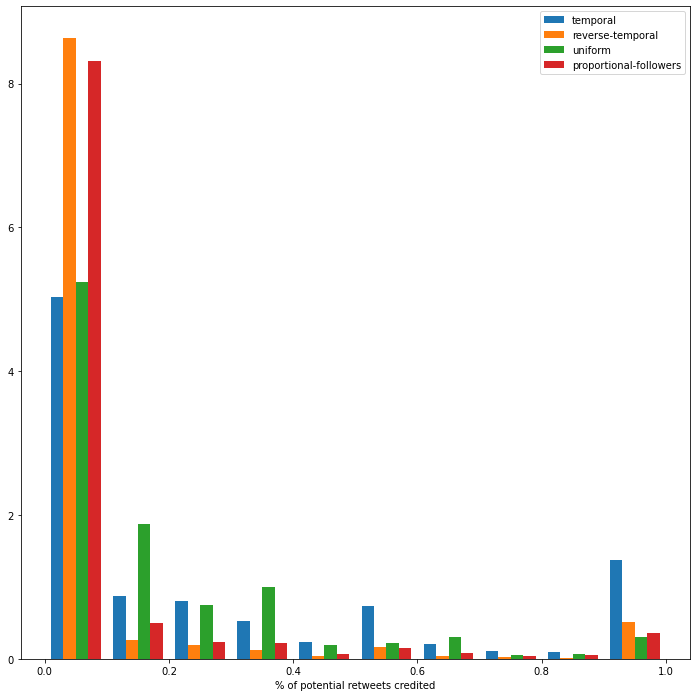

In [101]:
plt.figure(figsize=(12,12))
plt.hist(prop_res_dict.values(), label=list(prop_res_dict.keys()), density=True, bins=10)
        #, stacked=True)
plt.xlabel('% of potential retweets credited')
plt.legend()

In [113]:
prop_res_dict = defaultdict(list)
for cascade_root_id, dic in n_children_result_dict.items():
    max_possible = dic['flow-graph'] # this is the total number of candidates
    
    prop_res_dict['max-possible'] += list(max_possible)
    
    for name in ['temporal', 'reverse-temporal']:
        prop = dic[name]
        prop_res_dict[name] += list(prop)
    
    for name in ['uniform', 'proportional-followers']:        
        prop = (dic[name+'0'] + dic[name+'1'] + dic[name+'2'])/3
        prop_res_dict[name] += list(prop)

        #prop_res_dict[name].append(prop)

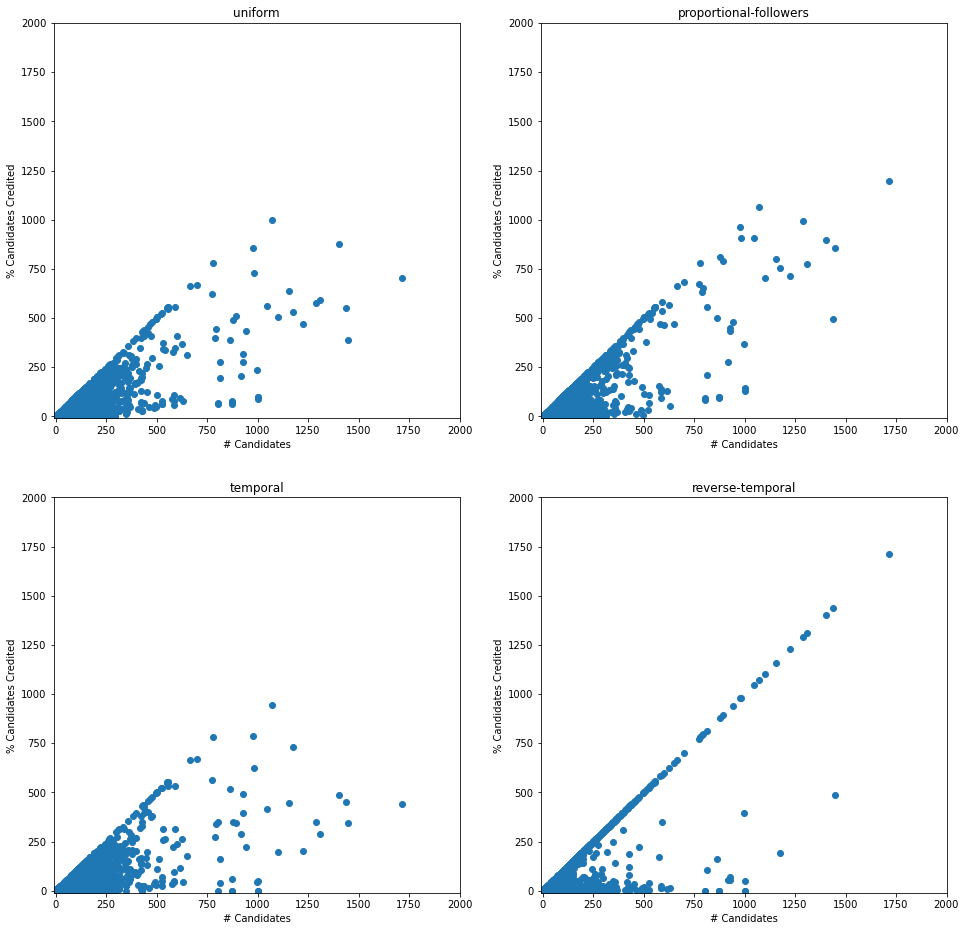

In [118]:
fig, ax = plt.subplots(2,2, figsize=(16,16))
#                       sharex=True, sharey = True, )
def mini_plot(ax, x):
    ax.scatter(prop_res_dict['max-possible'], prop_res_dict[x])
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    ax.set_xlim(-10, 2000)
    ax.set_ylim(-10, 2000)
    ax.set_title(x)
    ax.set_xlabel('# Candidates')
    ax.set_ylabel('% Candidates Credited')


mini_plot(ax[0,0], 'uniform')
mini_plot(ax[0,1], 'proportional-followers')
mini_plot(ax[1,0], 'temporal')
mini_plot(ax[1,1], 'reverse-temporal')


<ipython-input-95-0ba3d69ff5da>:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 2000)


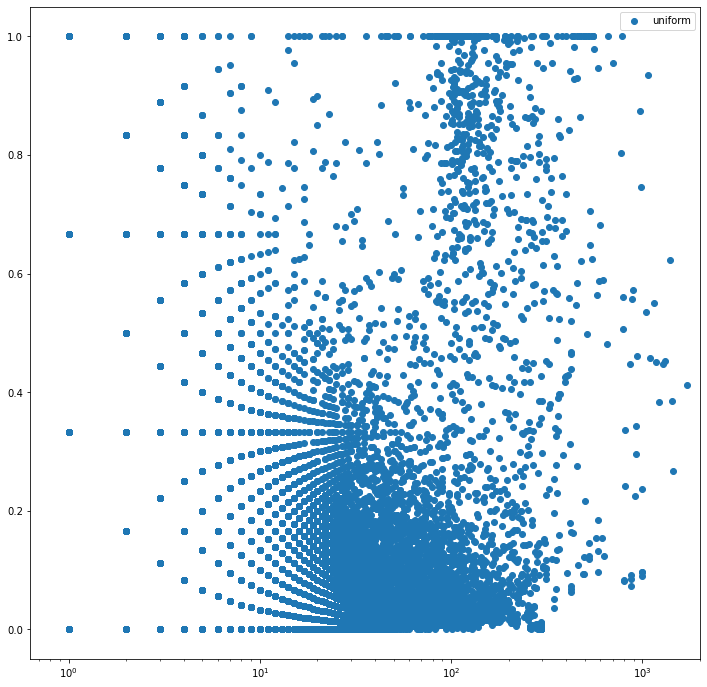

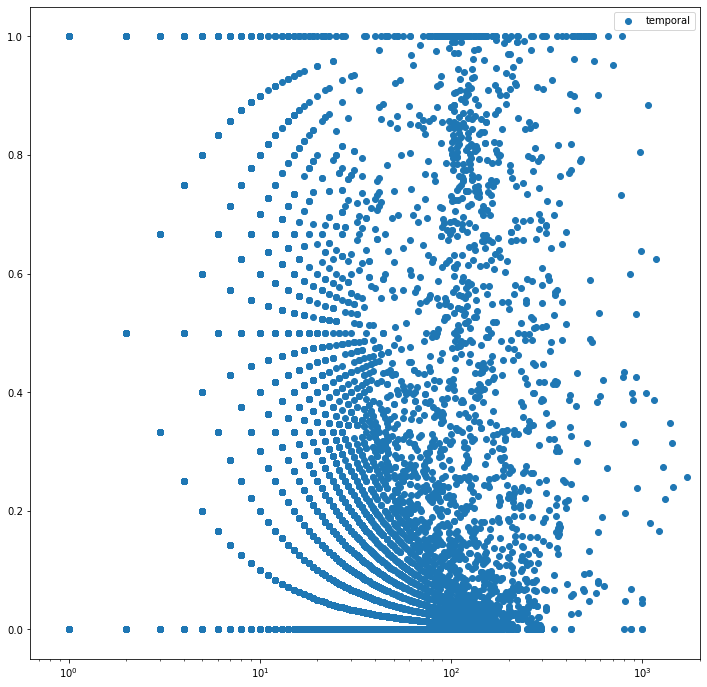

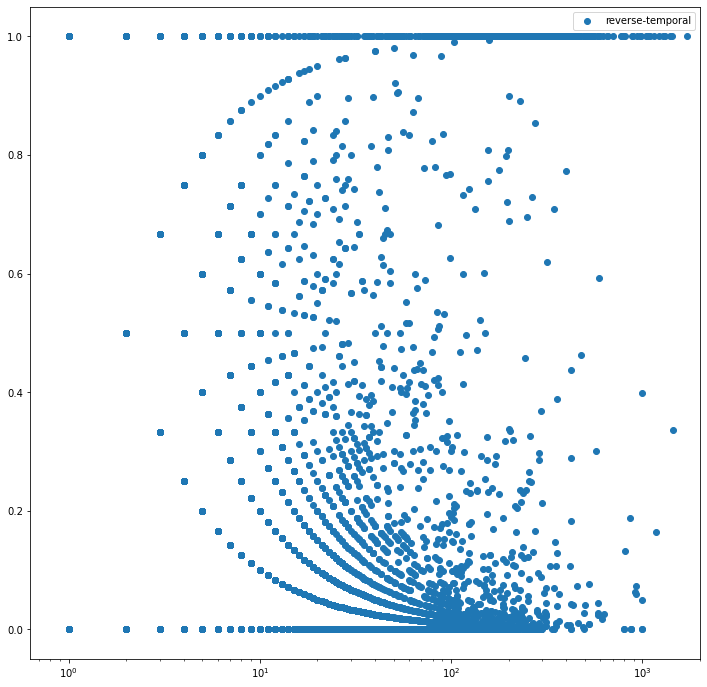

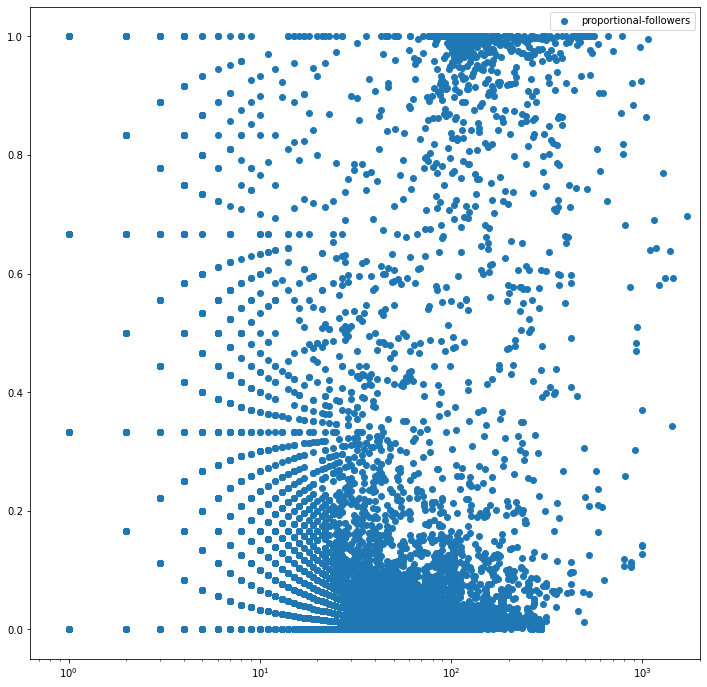

In [95]:
for x in ['uniform', 'temporal', 'reverse-temporal', 'proportional-followers']:
    plt.figure(figsize=(12,12))
    plt.scatter(prop_res_dict['max-possible'], prop_res_dict[x], label=x)
    plt.xscale('log')
    plt.legend()
    plt.xlim(0, 2000)
    plt.show()


In [82]:
prop_res_dict

defaultdict(list,
            {'max-possible': array([373,   1,  22,   5,  37,   1,   1,  30,   2,   3,  32,   3,   1,
                     57,  55,   2,  35,   5,   2,   2,   3,   6,   3,   1,  11,   1,
                      1,   4,   2,   2,   2,   1,   2,   3,   2,   1,   1,   1,   1,
                      5,   1], dtype=uint64),
             'temporal': [array([0.76407507, 0.        , 0.13636364, 0.        , 0.18918919,
                     0.        , 0.        , 0.06666667, 0.5       , 1.        ,
                     0.25      , 0.        , 0.        , 0.01754386, 0.47272727,
                     0.5       , 0.37142857, 0.2       , 0.        , 0.        ,
                     0.        , 0.33333333, 0.66666667, 0.        , 0.45454545,
                     1.        , 0.        , 0.25      , 0.5       , 1.        ,
                     0.        , 0.        , 0.5       , 0.66666667, 1.        ,
                     1.        , 1.        , 1.        , 1.        , 1.        ,
     

## User Type Distributions Under Different Attribution Models

In [18]:
users = preprocessing.load_user_data()
users.head()

,templates,template_retweets,tweets,retweets,campaigns,id,location,description,followers,friends,statuses,type,new_description,temp,group
4bhi9,0,0,4,27,0,NaN,NaN,NaN,NaN,NaN,NaN,6_non-participant,None,non-participant,0
advrayadav,0,0,0,14,0,68160779,"uttar pradesh & delhi , india","advocate supreme court of india, national pres...",11560,12591,24663,6_non-participant,None,non-participant,0
deepsethi01,13,40,23,195,4,773812588228534272,"kota,rajasthan",loksabha vice coordinator bjp .blessed to be f...,1680,923,72646,2_official,Loksabha Vice Coordinator BJP .\n\nBlessed to ...,loksabha vice coordin bjp bless to be follow ...,3-5
desh_bhkt,0,0,24,33,0,1465206535,dabru dabru dabru.hahahaha.com,make fun of life before it starts making fun o...,23672,135,116912,6_non-participant,None,non-participant,0
devendrapai,0,0,12,7,0,53862134,amchi mumbai,course director at rmp's @iidlpgp. swayamsevak...,7398,990,45891,6_non-participant,None,non-participant,0


In [166]:
thresh = -1 # this is the number of retweets to consider

top_tweets = defaultdict(list)
for c in tqdm(cascade_list):  
    networks = [('temporal', ''), ('reverse-temporal', ''),
               ('proportional-followers', '0'),
                ('uniform', '0')]    
    for name, n in networks:
        g = c.create_network(name, suffix=n)
        locs = np.where(g.get_out_degrees(g.get_vertices()) >= thresh)
        top_tweets[name] += [(g.vp.vertex_to_tweet[v], g.vertex(v).out_degree()) for v in locs[0]]

100%|██████████| 1423/1423 [02:18<00:00, 10.25it/s]


In [167]:
def summarize_top_tweets(top_tweets, rt_thresh=-1):
    # input: [(Tweet, (implied) RT count)]
    # output: info about these tweets
    labels = []#[get_user_type(tweet.username) for tweet, rt_count in top_tweets]
    rt_counts = []#[rt_count for tweet, rt_count in top_tweets]
    
    label_dict = {}
    for tweet, rt_count in top_tweets:
        if rt_count > rt_thresh:
            user_type = users.type.get(tweet.username, 'Unknown')
            labels.append(user_type)
            rt_counts.append(rt_count+1)
            temp = label_dict.get(user_type, [])
            temp.append(rt_count+1)
            label_dict[user_type] = temp
        else:
            print('bug')
    return label_dict

In [168]:
color_map = {
    '1_itcell': 'b',
    '2_official': 'orange',
    '3_fan': 'g',
    '4_other': 'r',
    '5_deleted': 'm',
    '6_non-participant': 'brown',
    'Unknown': 'pink'
}
import matplotlib.colors

In [169]:
def plot_attribution(attr, plt=plt):
    label_dict = summarize_top_tweets(top_tweets[attr])
    keys, values = list(label_dict.keys()), list(label_dict.values())
    sorted_keys, sorted_values = zip(*sorted(zip(keys, values), key=lambda x: x[0]))
    print([len(x) for x in sorted_values])
    colors = [matplotlib.colors.to_rgba(color_map[k]) for k in sorted_keys]
    
    logbins = np.geomspace(10, 1000, 20)
    plt.hist(sorted_values, stacked=True, label=sorted_keys, color=colors, bins=logbins)
    plt.legend()
    plt.set_xscale('log')
    plt.set_yscale('log')

    plt.set_xlabel('# Inferred Retweets')
    plt.set_ylabel('# Tweets')
    plt.set_title(f'{attr}')
    #plt.savefig('top_tweets_by_user.png')

[5419, 1707, 7553, 9194, 360, 203976, 1976]
[5419, 1707, 7553, 9194, 360, 203976, 1976]
[5419, 1707, 7553, 9194, 360, 203976, 1976]
[5419, 1707, 7553, 9194, 360, 203976, 1976]


Text(0.5, 0.98, 'Distribution of Tweets with 50+ RTs by User Type under Various Attribution Models')

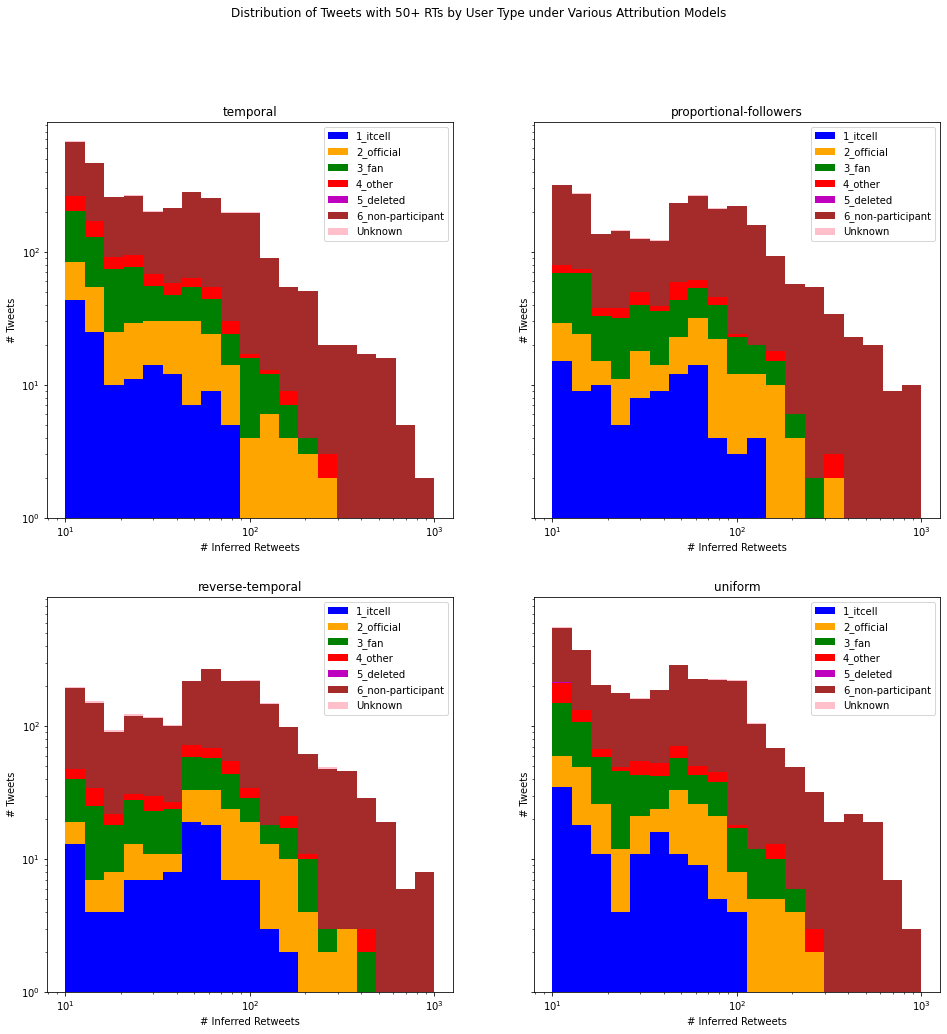

In [170]:
fig, ax = plt.subplots(2,2, figsize=(16,16), sharey=True)
plot_attribution('temporal', ax[0,0])
plot_attribution('reverse-temporal', ax[1,0])
plot_attribution('proportional-followers', ax[0,1])
plot_attribution('uniform', ax[1,1])
fig.suptitle(f'Distribution of Tweets with {MIN_RETWEETS}+ RTs by User Type under Various Attribution Models')

[3678, 1205, 5381, 6547, 259, 158131, 1355]
[3678, 1205, 5381, 6547, 259, 158131, 1355]
[3678, 1205, 5381, 6547, 259, 158131, 1355]
[3678, 1205, 5381, 6547, 259, 158131, 1355]


Text(0.5, 0.98, 'Distribution of Tweets with 100+ RTs by User Type under Various Attribution Models')

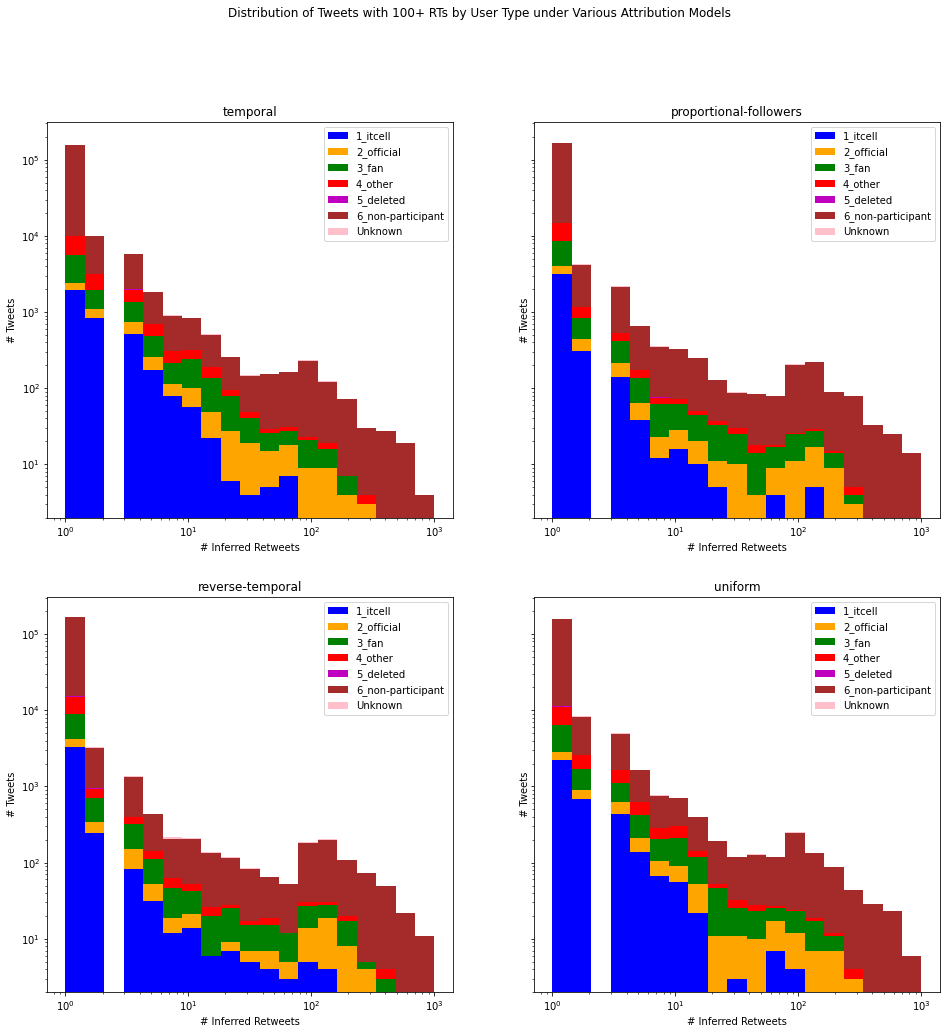

In [146]:
fig, ax = plt.subplots(2,2, figsize=(16,16), sharey=True)
plot_attribution('temporal', ax[0,0])
plot_attribution('reverse-temporal', ax[1,0])
plot_attribution('proportional-followers', ax[0,1])
plot_attribution('uniform', ax[1,1])
fig.suptitle(f'Distribution of Tweets with {MIN_RETWEETS}+ RTs by User Type under Various Attribution Models')

## Template RTs

In [152]:
template_cascade_list = [c for c in cascade_list if c.root.template != '']

In [153]:
thresh = -1 # this is the number of retweets to consider

top_tweets = defaultdict(list)
for c in tqdm(template_cascade_list):  
    networks = [('temporal', ''), ('reverse-temporal', ''),
               ('proportional-followers', '0'),
                ('uniform', '0')]    
    for name, n in networks:
        g = c.create_network(name, suffix=n)
        locs = np.where(g.get_out_degrees(g.get_vertices()) >= thresh)
        top_tweets[name] += [(g.vp.vertex_to_tweet[v], g.vertex(v).out_degree()) for v in locs[0]]

100%|██████████| 36/36 [00:04<00:00,  8.46it/s]


In [154]:
def summarize_top_tweets(top_tweets, rt_thresh=-1):
    # input: [(Tweet, (implied) RT count)]
    # output: info about these tweets
    labels = []#[get_user_type(tweet.username) for tweet, rt_count in top_tweets]
    rt_counts = []#[rt_count for tweet, rt_count in top_tweets]
    
    label_dict = {}
    for tweet, rt_count in top_tweets:
        if rt_count > rt_thresh:
            user_type = users.type.get(tweet.username, 'Unknown')
            labels.append(user_type)
            rt_counts.append(rt_count+1)
            temp = label_dict.get(user_type, [])
            temp.append(rt_count+1)
            label_dict[user_type] = temp
        else:
            print('bug')
    return label_dict

In [155]:
color_map = {
    '1_itcell': 'b',
    '2_official': 'orange',
    '3_fan': 'g',
    '4_other': 'r',
    '5_deleted': 'm',
    '6_non-participant': 'brown',
    'Unknown': 'pink'
}
import matplotlib.colors

In [164]:
def plot_attribution(attr, plt=plt):
    label_dict = summarize_top_tweets(top_tweets[attr])
    keys, values = list(label_dict.keys()), list(label_dict.values())
    sorted_keys, sorted_values = zip(*sorted(zip(keys, values), key=lambda x: x[0]))
    print([len(x) for x in sorted_values])
    colors = [matplotlib.colors.to_rgba(color_map[k]) for k in sorted_keys]
    
    logbins = np.geomspace(2, 1000, 20)
    plt.hist(sorted_values, stacked=True, label=sorted_keys, color=colors, bins=logbins)
    plt.legend()
    plt.set_xscale('log')
    plt.set_yscale('log')

    plt.set_xlabel('# Inferred Retweets')
    plt.set_ylabel('# Tweets')
    plt.set_title(f'{attr}')
    #plt.savefig('top_tweets_by_user.png')

[153, 52, 162, 477, 7, 2620, 38]
[153, 52, 162, 477, 7, 2620, 38]
[153, 52, 162, 477, 7, 2620, 38]
[153, 52, 162, 477, 7, 2620, 38]


Text(0.5, 0.98, 'Distribution of Tweets with 50+ RTs by User Type under Various Attribution Models')

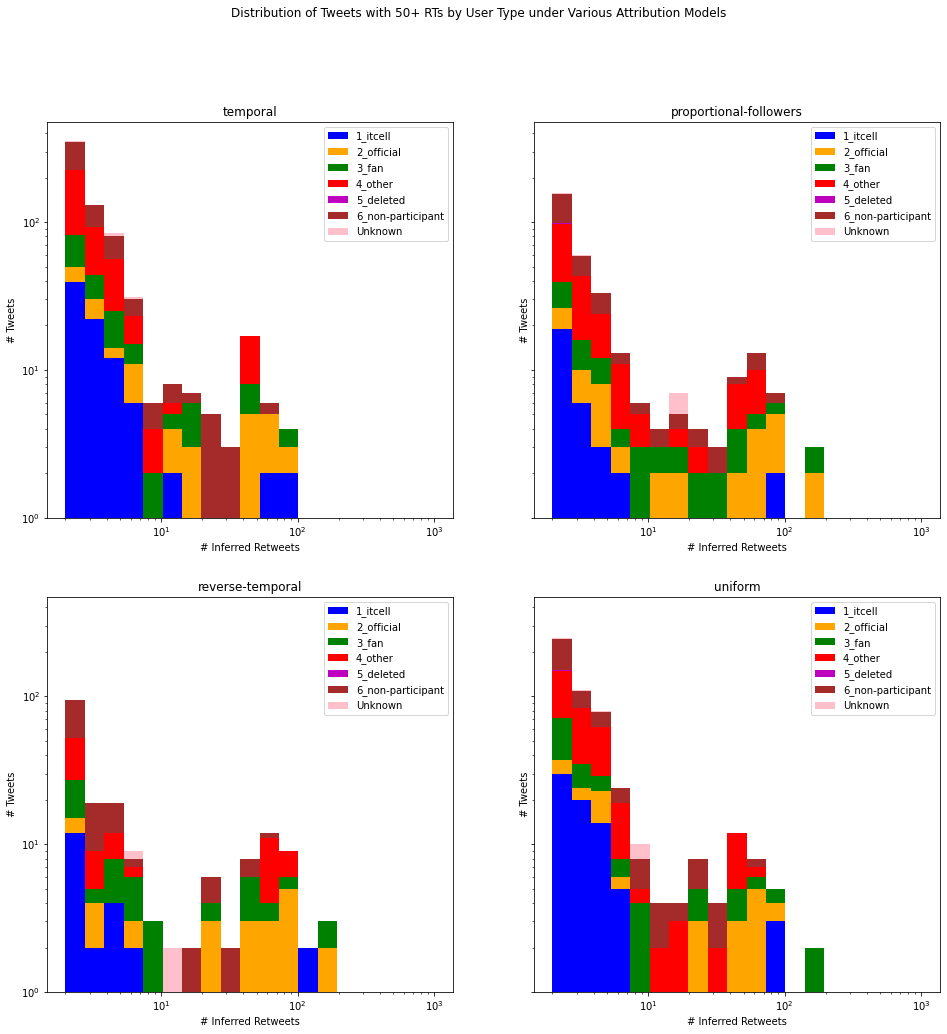

In [165]:
fig, ax = plt.subplots(2,2, figsize=(16,16), sharey=True)
plot_attribution('temporal', ax[0,0])
plot_attribution('reverse-temporal', ax[1,0])
plot_attribution('proportional-followers', ax[0,1])
plot_attribution('uniform', ax[1,1])
fig.suptitle(f'Distribution of Tweets with {MIN_RETWEETS}+ RTs by User Type under Various Attribution Models')